# signal processing types
## single folder one by one with config

# Processes all raw data (binary) and puts it into summary_features_csv file for each device label file

In [7]:
import raw_data_processing as proc
import os
import re
import pandas as pd

# ---------------------------
# Main Processing Function
# ---------------------------

def main():
    # Load configuration
    try:
        config = proc.load_config('config.json')
    except (FileNotFoundError, KeyError, ValueError) as e:
        print(f"Configuration Error: {e}")
        return

    base_dir = config['base_dir']
    decimation_factor = config.get('decimation_factor', 1024)  # Default to 1024 if not specified
    batch_size = 16384

    # Prompt user for data augmentation
    augment_choice = input("Do you want to augment the data with overlapping chunks? (yes/no): ").strip().lower()
    if augment_choice in ['yes', 'y']:
        augment = True
        output_filename = 'summary_features_augmented.csv'
        print("Data augmentation enabled. Using overlapping chunks.")
    else:
        augment = False
        output_filename = 'summary_features.csv'
        print("Data augmentation disabled.")

    # Get list of devices in base_dir
    device_labels = [d for d in os.listdir(base_dir) if os.path.isdir(os.path.join(base_dir, d))]

    for device_label in device_labels:
        device_dir_path = os.path.join(base_dir, device_label)
        if device_label == 'live':
            continue
        print(f"\nProcessing device: {device_label}")

        # Initialize a list to collect session data
        summary_data = []

        # Iterate over date directories
        date_dirs = [d for d in os.listdir(device_dir_path) if os.path.isdir(os.path.join(device_dir_path, d))]
        for date_dir in sorted(date_dirs):
            date_dir_path = os.path.join(device_dir_path, date_dir)

            print(f"Processing date directory: {date_dir_path}")

            # Find all session_###.bin files
            session_pattern = re.compile(r'session_(\d{3})\.bin')
            for filename in sorted(os.listdir(date_dir_path)):
                match = session_pattern.match(filename)
                if match:
                    session_number = match.group(1)
                    binary_filepath = os.path.join(date_dir_path, filename)

                    print(f"Processing session {session_number}")

                    # Process the session
                    session_data_list = proc.process_session(binary_filepath, decimation_factor, batch_size, augment=augment)
                    if session_data_list:
                        for batch_data in session_data_list:
                            batch_data['device_label'] = device_label
                            summary_data.append(batch_data)
                        print(f"Session {session_number} processed successfully.")
                    else:
                        print(f"Failed to process session {session_number} in {date_dir_path}")

        if summary_data:
            # Convert the list of dictionaries to a DataFrame
            summary_df = pd.DataFrame(summary_data)

            # Define the output summary CSV path
            output_summary_path = os.path.join(base_dir, device_label, output_filename)

            # Save the summary DataFrame to CSV
            try:
                summary_df.to_csv(output_summary_path, index=False)
                print(f"Summary CSV successfully saved to {output_summary_path}")
            except Exception as e:
                print(f"Failed to save summary CSV: {e}")
        else:
            print(f"No data processed for device '{device_label}'.")

# ---------------------------
# Entry Point
# ---------------------------

if __name__ == "__main__":
    main()


Data augmentation enabled. Using overlapping chunks.

Processing device: empty
Processing date directory: /Volumes/One Touch/_data/empty/2024-12-02
Processing session 001
Session 001 processed successfully.
Processing session 002
Session 002 processed successfully.
Processing session 003
Session 003 processed successfully.
Processing session 004
Session 004 processed successfully.
Processing session 005
Session 005 processed successfully.
Processing session 006
Session 006 processed successfully.
Processing session 007
Session 007 processed successfully.
Processing session 008
Session 008 processed successfully.
Processing session 009
Session 009 processed successfully.
Processing session 010
Session 010 processed successfully.
Summary CSV successfully saved to /Volumes/One Touch/_data/empty/summary_features_augmented.csv

Processing device: lamp
Processing date directory: /Volumes/One Touch/_data/lamp/2024-12-02
Processing session 001
Session 001 processed successfully.
Processing ses

### merge all devices summary_features.csv into master_features.csv

Devices found:
1. empty
2. lamp
3. mac_aug_on
4. ipad_on


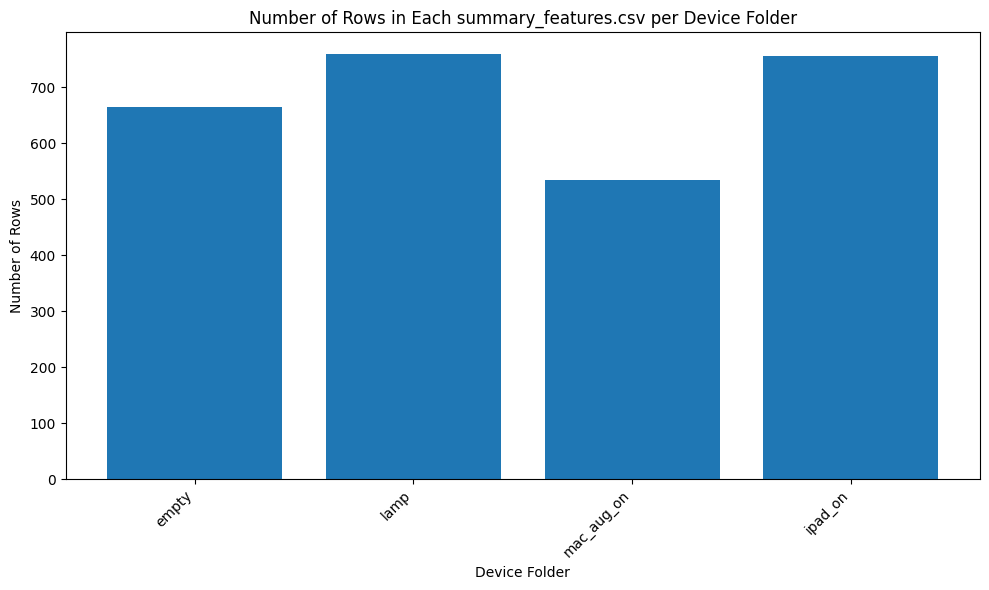

Processing: /Volumes/One Touch/_data/empty/summary_features_augmented.csv
Processing: /Volumes/One Touch/_data/lamp/summary_features_augmented.csv
Processing: /Volumes/One Touch/_data/mac_aug_on/summary_features_augmented.csv
Processing: /Volumes/One Touch/_data/ipad_on/summary_features_augmented.csv
'master_features.csv' has been created at: master_features.csv


In [8]:
import os
import json
import pandas as pd
import matplotlib.pyplot as plt

def load_config(config_path='config.json'):
    """
    Load configuration parameters from a JSON file.
    """
    if not os.path.exists(config_path):
        raise FileNotFoundError(f"Configuration file '{config_path}' not found.")
    
    with open(config_path, 'r') as f:
        config = json.load(f)
    
    required_keys = ['base_dir']
    for key in required_keys:
        if key not in config:
            raise KeyError(f"Missing required configuration key: '{key}'")
    
    return config

def get_device_folders(base_dir):
    """
    Get the list of device folders in the base directory.
    """
    return [folder for folder in os.listdir(base_dir) if os.path.isdir(os.path.join(base_dir, folder))]

def create_master_features(base_dir, excluded_indices, device_folders, output_file='master_features.csv'):
    """
    Combine all 'summary_features.csv' files into a single 'master_features.csv'.
    """
    master_df = pd.DataFrame()

    for idx, device_folder in enumerate(device_folders, start=1):
        if idx in excluded_indices:
            print(f"Skipping {device_folder}...")
            continue

        summary_file = os.path.join(base_dir, device_folder, 'summary_features_augmented.csv')
        if os.path.exists(summary_file):
            print(f"Processing: {summary_file}")
            df = pd.read_csv(summary_file)
            master_df = pd.concat([master_df, df], ignore_index=True)
        else:
            print(f"No 'summary_features.csv' found in: {device_folder}")

    # Save to master_features.csv
    master_df.to_csv(output_file, index=False)
    print(f"'master_features.csv' has been created at: {output_file}")

def plot_rows_per_device(base_dir, device_folders):
    """
    Plot the number of rows in each 'summary_features.csv' file for the device folders.
    """
    rows_data = []

    for device_folder in device_folders:
        summary_file = os.path.join(base_dir, device_folder, 'summary_features_augmented.csv')
        if os.path.exists(summary_file):
            df = pd.read_csv(summary_file)
            rows_data.append((device_folder, len(df)))
        else:
            rows_data.append((device_folder, 0))
    
    # Create a DataFrame for plotting
    plot_df = pd.DataFrame(rows_data, columns=['Device Folder', 'Row Count'])
    
    # Plotting
    plt.figure(figsize=(10, 6))
    plt.bar(plot_df['Device Folder'], plot_df['Row Count'])
    plt.xlabel('Device Folder')
    plt.ylabel('Number of Rows')
    plt.title('Number of Rows in Each summary_features.csv per Device Folder')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

def main():
    # Load configuration
    config = load_config('config.json')
    base_dir = config['base_dir']

    # Get the list of devices
    device_folders = get_device_folders(base_dir)
    print("Devices found:")
    for idx, device in enumerate(device_folders, start=1):
        print(f"{idx}. {device}")

    # Plot the rows per device folder
    plot_rows_per_device(base_dir, device_folders)

    # Ask the user which devices to exclude
    excluded_input = input("Enter the numbers of devices to exclude, separated by commas (e.g., 1,3,5): ")
    excluded_indices = [int(num.strip()) for num in excluded_input.split(',') if num.strip().isdigit()]

    # Create the master features file
    create_master_features(base_dir, excluded_indices, device_folders)

if __name__ == "__main__":
    main()
